# Практическая работа (Прореживание/pruning)

# Задача: Реализовать стратегию "Итеративное прореживание" для задачи классификации

В данной работе необходимо реализовать **прореживание** ранее обученной сети (```pruning```) модели. Для этого нам потребуется библиотека NNI, в которой реализован автоматический pruning: https://nni.readthedocs.io/en/stable/Compression/Overview.html

Прореживание нейронной сети основана на той идеи, что в сети много излишних нейронов, которые мало влияют на конечный выход сети. Отсюда возникает идея - взять хорошо обученную модель и устранить в ней как можно больше весов и операций, при этом не потеряв существенно в качестве. Более того, при небольшом прореживании обычно наблюдается повышение качества на тестовой выборке. Предположительно, ликвидация лишних параметров убирает "шумные веса" из модели и разрушает случайные закономерности, которые сеть обнаруживает на обучающей выборке, но не являющиеся характерным для всего распределения данных в целом. 

На практике сверточные сети можно прорядить от 60-95% потеряв в точности менее 1%. 

***Поиск удаляемых сверток***

Есть несколько вариантов выбора сверток для удаления:


 - Наименьшая ```L1-мера``` или low_magnitude_pruning. Идея, говорящая о том, что свертки с малыми значениями весов, вносят малый вклад в итоговое принятие решения
 - Наименьшая L1-мера с учетом среднего и стандартного отклонения. Дополняем оценкой характера распределения.
 - Маскирование сверток и исключение наименее влияющих на итоговую точность. Более точное определение малозначимых свёрток, но весьма затратное по времени и ресурсам.
 - Прочие

Какой метод лучше "сработает" зависит от конкретной задачи и выбранной архитектуры сети. 

**Существует несколько стратегий по прореживанию моделей:**

 - Однократное прореживание (**One-shot pruning**).

    Берется предварительно обученная модель и в определенный момент устраняется некоторая часть весов согласно алгоритму прореживания. Можно на этом этапе оставить все как есть, но обыкновенно продолжают обучение на протяжении еще некоторого количества эпох, тем более, что при использовании более грубых методов, вроде magnitude-based, качество первоначально может заметно просесть и восстановиться до уровня близкого в исходной модели, только после оптимизации. При этом важно дождаться сходимости к оптимуму, так как если проредить еще не оптимальную модель, итоговое качество будет несколько хуже.
    

 - Итеративное прореживание

    Модель прореживается постепенно. Через число шагов, определенных расписанием прореживания (```pruning schedule```), часть весов устраняется из модели, затем проводится дообучение модели. Данная процедура проводится некоторое количество раз до тех пор пока модель не достигнет требуемой разреженности. Здесь, как можно заметить, довольно большой простор для подбора гиперпараметров - сколько весов отбросить на данной итерации, сколько эпох обучать модель между каждой итерацией.
    

 - Обучение разреженной модели c самого начала

    Кроме того, можно стартовать сразу с разреженной модели, а затем уже по ходу дела убирать наименее важные веса и заодно наращивать новые веса (которые до этого были обращены в нуль) на основе некоторого критерия. Достоинством данного подхода является возможность обучения моделей, которые в плотном виде (dense) не помещаются в память устройства.



В данной работе продемонстрирую первую стратегию - Однократное прореживание, а вторую стратегию "Итеративное прореживание" нужно будет реализовать самостоятельно

### 1.1 Установка библиотеки

Для начала поставим нужные библиотеки с помощью терминальной команды pip. Терминальные команды можно использовать в Jupyter Notebook-ах и Colab-е. Для того, чтобы запустить терминальную команду, необходимо перед командой поставить восклицательный знак. Например, чтобы посмотреть содержимое папки, можно использовать команду ```!ls```.

In [ ]:
!pip3 install torchvision tqdm nni -q

### 1.2 Импортирование модулей

В этом практическом задании мы будем использовать несколько библиотек. Во-первых, это ```Pytorch``` и ```torchvision```. Кроме этого, нам понадобится ```NNI``` : при помощи него мы будем прореживать конвалюционные слои нейронные сети.

In [8]:
import numpy as np                       
import torch                       
import torchvision                       
from torch import nn                       
from torch.autograd import Variable                       
from torchvision.datasets import MNIST 
from torchvision.datasets import CIFAR10
import torchvision.transforms as T                      
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import time
from nni.algorithms.compression.pytorch.pruning import L1FilterPruner
from nni.algorithms.compression.pytorch.pruning import L2FilterPruner
from nni.compression.pytorch import ModelSpeedup

### 1.3 Воспроизводимое обучение

Для того, чтобы постепенно улучшать процесс обучения нейронной сети, необходимо позаботиться о том, чтобы результат обучения воспроизводился от запуска к запуску. Поскольку при обучении нейронных сетей часто используются псевдослучайные числа, необходимо, чтобы генераторы случайных чисел выдавали одни и те же последовательности от запуска к запуску. Кроме того, необходимо переключить CUDA в детерминированный режим. Это требование уменьшает скорость выполнения программы, зато результаты вычислений становятся воспроизводимыми.

In [9]:
seed=42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### 2.1 Определим функции для обучения

Класс ```MetricMonitor``` вспомогательный, который агригирует значения по каждому новому batch и выводит статистику онлайн накопительным образом. Это позволяет во время обучения мониторить изменение метрик.


In [10]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

Функция ```train``` отвечает за обучение. При этом, функция универсальная, тк работает с входными переменными: датасет ```train_loader```, модель ```model```, функцию ошибок ```criterion```, функцию оптимизации ```optimizer```, число эпох для обучения ```epochs``` и ```params```

Внутри функции мы бежим по всему нашему тренировочному датасету и пропускаем его через модель для определения градиентов ошибки по bath (```criterian```). Внутри цикла происходит обновление весов на основе ```backward```. Предсказание модели получаем с помощью функции argmax по последнему слою, а показатели ```Loss``` и ```Accuracy``` помещаем в класс ```MetricMonitor```. 
Библиотека ```tqdm``` помогает визуализировать бегунок прогресса и значения, которые передаются в класс ```MetricMonitor```

Функция ```validate```  отчечает за прогон данных на валидационной выборке ```val_loader``` и так же универсальна, тк большую часть переменных получает извне.

In [11]:
def train(train_loader, model, criterion, optimizer, epochs, params):
    metric_monitor = MetricMonitor()
    model.train()
    eterator = tqdm(train_loader)
    for i, data in enumerate(eterator, start=1):
        
        image, label = data
        image = image.to(params["device"], non_blocking=True)
        label = label.to(params["device"], non_blocking=True)
        output = model(image)
        pred = output.argmax(dim=1, keepdim=True)
        loss = criterion(output, label)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", pred.eq(label.view_as(pred)).sum().item()/pred.shape[0]) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        eterator.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epochs, metric_monitor=metric_monitor)
        )
        
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    eterator = tqdm(val_loader)
    
    with torch.no_grad():
        for i, (image, label) in enumerate(eterator, start=1):
            image = image.to(params["device"], non_blocking=True)
            label = label.to(params["device"], non_blocking=True)
            output = model(image)
            pred = output.argmax(dim=1, keepdim=True)
            loss = criterion(output, label)
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", pred.eq(label.view_as(pred)).sum().item()/pred.shape[0])
            eterator.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
            
    return metric_monitor
            

### 2.2 Определим функцию паплайна(```pipeline```) для обучения

Функция ```train_and_validate``` инициализирует train и valid датасет, задает функцию потерь (```CrossEntropyLoss```) и фунцию оптимизации ```AdamW```, затем последовательно в Эпохе вызывает ранее определенную функцию обучения и функцию валидации.
Обращаю внимание, что этот паплайн возвращает в качестве результата обученную модель.

In [24]:
def train_and_validate(model, train_dataset, val_dataset, params):    
    
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=params["batch_size"],
                              num_workers=params["num_workers"],
                              pin_memory=True,
                              shuffle=True,
                              drop_last = True)
    
    val_loader = DataLoader(dataset=val_dataset,
                              batch_size=params["batch_size"],
                              num_workers=params["num_workers"],
                              pin_memory=True,
                              shuffle=True)
    best_metric = 1000
    
    criterion =  nn.CrossEntropyLoss().to(params["device"])
    optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"])
    
    for epoch in range(1, params["epochs"] + 1):
        train(train_loader, model, criterion, optimizer, epoch, params)
        metric_monitor_ = validate(val_loader, model, criterion, epoch, params)
        
        metric = metric_monitor_.metrics['Accuracy']['avg']

        if best_metric > metric:
            best_metric = metric
            torch.save(model.state_dict(), "./best_model.pth")
            
    torch.save(model.state_dict(), "./final_model.pth")
    
    return model


### 3.1 Инициализация датасетов

В этом ноутбуке мы не будем писать своих датасетов, а будем использовать те, что имеются в наличии во вспомогательной библиотеке `torchvision`. Нас будет интересовать датасет `Cifar10` (10 классов).

1. Изучите интерфейс класса `torchvision.datasets.CIFAR10`. Посмотрите, какими параметрами можно влиять на этот датасет.

2. Инициализируйте тренировочный и тестовый датасеты (`torchvision.datasets.CIFAR10`). 

3. В конструкторе используйте следующие параметры:
    * аугментации из `torchvision.transforms`:
        * `T.ToTensor()`
        * `T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),`

    * `root` -- любой на Ваш вкус
    * проанализируйте и выставьте остальные аргументы так, как вам кажется правильнее. Не забывайте, что перемешивать датасет имеет смысл для тренировочной выборки.


In [6]:
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

data_train = CIFAR10(root="./Cifar",train = True, transform = preprocess, download=True)
data_test = CIFAR10(root="./Cifar",train = False, transform = preprocess, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./Cifar/cifar-10-python.tar.gz to ./Cifar
Files already downloaded and verified


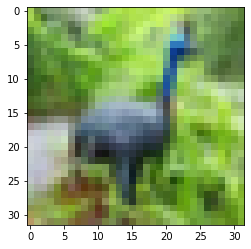

In [14]:
plt.imshow(data_train.data[6])

### 4.1 Проведем файн-тюнинг модели

Для файн-тюнинга модели будем использорвать предобученную модель ResNet18 из библиотеки ```torchvision```. В оригинале модель обучена на датасете Imagenet, где предсказанием является один из 1000 классов. В нашем случае ответ модели другой, поэтому заменим последний линейный слой ```fc``` на слой с 10 нейронами, что соответствует количеству классов в нашем датасете.

In [15]:
model = torchvision.models.resnet18( pretrained= True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/kravtsev-vs/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [19]:
model = torchvision.models.resnet18(pretrained= True)
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)
model = model.to(params["device"])

Зададим прочие параметры обучения в объект типа dict ```params```

In [22]:
params = {
    "device": "cpu",
    "lr": 0.0001,
    "batch_size": 128,
    "num_workers": 8,
    "epochs": 5,
}

И запустим обучение

In [ ]:
model = train_and_validate(model, data_train, data_test, params)

### 5.1 Оптимизация(прунинг) ранее обученно модели

Проведем оптимизацию моделей двумя разными методами для сравнения ```L1FilterPruner``` (https://arxiv.org/pdf/1608.08710.pdf) и ```L2FilterPruner```. Подробнее о методах можно узнать в оригинальных статьях, ниже освежим в памяти алгоритм для L1Filter Pruner.


L1Filter Pruner удаляет фильтры в сверточных слоях

Процедура обрезки m фильтров из i-го сверточного слоя выглядит следующим образом:

Для каждого фильтра http://latex.codecogs.com/gif.latex?F_%7Bi,j%7Dвычислите сумму его абсолютных весов ядраhttp://latex.codecogs.com/gif.latex?s_j=%5Csum_%7Bl=1%7D%5E%7Bn_i%7D%5Csum%7CK_l%7C
Отсортируйте фильтры по http://latex.codecogs.com/gif.latex?s_j.
Сократите http://latex.codecogs.com/gif.latex?mфильтры с наименьшими значениями суммы и их соответствующими картами признаков. Ядра в следующем сверточном слое, соответствующем сокращенным картам объектов, также удаляются.
Новая матрица ядра создается как для слоя th, так http://latex.codecogs.com/gif.latex?iи http://latex.codecogs.com/gif.latex?i+1для слоя th, а оставшиеся веса ядра копируются в новую модель.

сохраним результаты прореженных моделей "model_prunel1.pth" и "model_prunel2.pth"

In [ ]:
#Задаем конфигурацию прореживания - Conv2d стой и sparsity 0,5 (или сремимся убрать 50% фильтров)
config_list = [{ 'sparsity': 0.5, 'op_types': ['Conv2d'] }]

#Загружаем лучшую модель
model = torchvision.models.resnet18( pretrained= False)
model_w = torch.load ("./best_model.pth", map_location="cpu")
model.load_state_dict(model_w).eval()

#Создаем тензор для поиска кандидатов на прореживания
dummy_input = torch.randn(1, 3, 32, 32).to("cpu")


#Запускаем алгоритм поиска кандидатов на прореживания, в результате сохраним веса новой модеои и маску прореженного графа сети
pruner = L1FilterPruner(model, config_list);
pruned_model = pruner.compress();
pruner.export_model(model_path='./test.pt', mask_path='./test_mask.pt')

#Применим новые веса для ускорения модели, для чего заново загрузим модель и в соответствии с маской удалим ненужные веса 
model_new = torchvision.models.resnet18( pretrained= False)
model_w = torch.load ("./best_model.pth", map_location="cpu")
model_new.load_state_dict(model_w).eval()
m_speedup = ModelSpeedup(model_new, dummy_input, './test_mask.pt')
m_speedup.speedup_model();


torch.save(m, "./model_prunel1.pth")

Проведем ту же операцию с L2Filter Pruner.

In [29]:
config_list = [{ 'sparsity': 0.5, 'op_types': ['Conv2d'] }]

model = torchvision.models.resnet18( pretrained= False)
model_w = torch.load ("./best_model.pth", map_location="cpu")
model.load_state_dict(model_w).eval()


dummy_input = torch.randn(1, 3, 32, 32).to("cpu")

pruner = L2FilterPruner(model, config_list) 
pruned_model = pruner.compress();
pruner.export_model(model_path='./test.pt', mask_path='./test_mask.pt')

model_new = torchvision.models.resnet18( pretrained= False)
model_w = torch.load ("./best_model.pth", map_location="cpu")
model_new.load_state_dict(model_w).eval()
m_speedup = ModelSpeedup(model_new, dummy_input, './test_mask.pt')
m_speedup.speedup_model();

torch.save(m, "./model_prunel2.pth")

[2022-04-08 19:11:54] INFO (nni.compression.pytorch.compressor/MainThread) Model state_dict saved to ./test.pt
[2022-04-08 19:11:54] INFO (nni.compression.pytorch.compressor/MainThread) Mask dict saved to ./test_mask.pt
[2022-04-08 19:11:55] INFO (nni.compression.pytorch.speedup.compressor/MainThread) start to speed up the model
[2022-04-08 19:11:55] INFO (FixMaskConflict/MainThread) {'conv1': 1, 'layer1.0.conv1': 1, 'layer1.0.conv2': 1, 'layer1.1.conv1': 1, 'layer1.1.conv2': 1, 'layer2.0.conv1': 1, 'layer2.0.conv2': 1, 'layer2.0.downsample.0': 1, 'layer2.1.conv1': 1, 'layer2.1.conv2': 1, 'layer3.0.conv1': 1, 'layer3.0.conv2': 1, 'layer3.0.downsample.0': 1, 'layer3.1.conv1': 1, 'layer3.1.conv2': 1, 'layer4.0.conv1': 1, 'layer4.0.conv2': 1, 'layer4.0.downsample.0': 1, 'layer4.1.conv1': 1, 'layer4.1.conv2': 1}
[2022-04-08 19:11:55] INFO (FixMaskConflict/MainThread) dim0 sparsity: 0.500000
[2022-04-08 19:11:55] INFO (FixMaskConflict/MainThread) dim1 sparsity: 0.000000
[2022-04-08 19:11:55

[2022-04-08 19:11:56] INFO (nni.compression.pytorch.speedup.compressor/MainThread) Update mask for layer4.1.conv2
[2022-04-08 19:11:56] INFO (nni.compression.pytorch.speedup.compressor/MainThread) Update mask for layer4.1.bn2
[2022-04-08 19:11:56] INFO (nni.compression.pytorch.speedup.compressor/MainThread) Update mask for layer4.1.aten::add_.68
[2022-04-08 19:11:56] INFO (nni.compression.pytorch.speedup.compressor/MainThread) Update mask for layer4.1.relu
[2022-04-08 19:11:56] INFO (nni.compression.pytorch.speedup.compressor/MainThread) Update mask for avgpool
[2022-04-08 19:11:56] INFO (nni.compression.pytorch.speedup.compressor/MainThread) Update mask for .aten::flatten.60
[2022-04-08 19:11:56] INFO (nni.compression.pytorch.speedup.compressor/MainThread) Update mask for fc
[2022-04-08 19:11:56] INFO (nni.compression.pytorch.speedup.compressor/MainThread) Update the indirect sparsity for the fc
[2022-04-08 19:11:56] INFO (nni.compression.pytorch.speedup.compressor/MainThread) Update 

[2022-04-08 19:11:57] INFO (nni.compression.pytorch.speedup.compressor/MainThread) Update the indirect sparsity for the layer1.1.relu
[2022-04-08 19:11:57] INFO (nni.compression.pytorch.speedup.compressor/MainThread) Update the indirect sparsity for the layer1.1.bn1
[2022-04-08 19:11:57] INFO (nni.compression.pytorch.speedup.compressor/MainThread) Update the indirect sparsity for the layer1.1.conv1
[2022-04-08 19:11:57] INFO (nni.compression.pytorch.speedup.compressor/MainThread) Update the indirect sparsity for the layer1.0.relu.1
[2022-04-08 19:11:57] INFO (nni.compression.pytorch.speedup.compressor/MainThread) Update the indirect sparsity for the layer1.0.aten::add_.61
[2022-04-08 19:11:57] INFO (nni.compression.pytorch.speedup.compressor/MainThread) Update the indirect sparsity for the layer1.0.bn2
[2022-04-08 19:11:57] INFO (nni.compression.pytorch.speedup.compressor/MainThread) Update the indirect sparsity for the layer1.0.conv2
[2022-04-08 19:11:57] INFO (nni.compression.pytorch

[2022-04-08 19:11:57] INFO (nni.compression.pytorch.speedup.compressor/MainThread) replace module (name: layer3.0.conv1, op_type: Conv2d)
[2022-04-08 19:11:57] INFO (nni.compression.pytorch.speedup.compressor/MainThread) replace module (name: layer3.0.downsample.0, op_type: Conv2d)
[2022-04-08 19:11:57] INFO (nni.compression.pytorch.speedup.compressor/MainThread) replace module (name: layer3.0.bn1, op_type: BatchNorm2d)
[2022-04-08 19:11:57] INFO (nni.compression.pytorch.speedup.compress_modules/MainThread) replace batchnorm2d with num_features: 128
[2022-04-08 19:11:57] INFO (nni.compression.pytorch.speedup.compressor/MainThread) replace module (name: layer3.0.downsample.1, op_type: BatchNorm2d)
[2022-04-08 19:11:57] INFO (nni.compression.pytorch.speedup.compress_modules/MainThread) replace batchnorm2d with num_features: 239
[2022-04-08 19:11:57] INFO (nni.compression.pytorch.speedup.compressor/MainThread) replace module (name: layer3.0.relu, op_type: ReLU)
[2022-04-08 19:11:57] INFO 

### 5.2 Анализ результатов

Проведем анализ получившихся результатов по рамеру моделей и  скорости работы. Для этого создадим функцию оценки количества весов модели
```get_n_params```

In [30]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [31]:
model_prunel1 = torch.load ("./model_prunel1.pth", map_location="cpu").eval()
model_prunel2 = torch.load ("./model_prunel2.pth", map_location="cpu").eval()

model = torchvision.models.resnet18( pretrained= False)
model_w = torch.load ("./best_model.pth", map_location="cpu")
model.load_state_dict(model_w).eval()

dummy_input = torch.ones(128, 3, 32, 32).to("cpu")

In [36]:
get_n_params(model_prunel1)

5159194

In [37]:
print ("L1pruning {metric1}%, L2pruning {metric2}% parametr of original".format( \
                                    metric1=round(get_n_params(model_prunel1)/get_n_params(model)*100,2), \
                                    metric2=round(get_n_params(model_prunel2)/get_n_params(model)*100,2)))

L1pruning 46.14%, L2pruning 46.38% parametr of original


In [38]:
%%timeit
model(dummy_input)

213 ms ± 9.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%%timeit
model_prunel1(dummy_input)

117 ms ± 916 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
%%timeit
model_prunel2(dummy_input)

116 ms ± 240 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 5.3 Дообучение пруниных моделей

После прунинга точность моделей заметно уменьшается, поэтому требуется дообучение. 

In [43]:
params = {
    "device": "cpu",
    "lr": 0.0001,
    "batch_size": 128,
    "num_workers": 8,
    "epochs": 15,
}

In [ ]:
model_prunel1 = train_and_validate(model_prunel1.to("cpu"), data_train, data_test, params)

In [ ]:
model_prunel2 = train_and_validate(model_prunel2.to("cuda"), data_train, data_test, params)